# Disagreement metrics

_Alex Malz (GCCL@RUB)_ and _Mi Dai_, _Kara Ponder_ {add your names here!}

In [1]:
import itertools
import numpy as np
import os
import sys
epsilon = sys.float_info.epsilon

In [2]:
import matplotlib as mpl
mpl.use('PS')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["mathtext.fontset"] = "dejavuserif"
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import pylab
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
label_dict = {90: 'SNIa',
              67: 'SNIa-91bg',
              52: 'SNIax',
              42: 'SNII',
              62: 'SNIbc',
              95: 'SLSN-I',
              15: 'TDE',
              64: 'KN',
              88: 'AGN',
              92: 'RRL',
              65: 'M-dwarf',
              16: 'EB',
              53: 'Mira',
              6: r'$\mu$Lens-Single'}

true_labels = label_dict.copy()
true_labels[991] = r'$\mu$Lens-Binary'
true_labels[992] = 'ILOT'
true_labels[993] = 'CaRT'
true_labels[994] = 'PISN'
true_labels[995] = r'$mu$Lens-String'

sub_labels = label_dict.copy()
sub_labels[99] = 'Other'

In [4]:
contestants = ['1_Kyle', '2_MikeSilogram', '3_MajorTom', '4_AhmetErdem','5_SKZLostInTranslation','6_StefanStefanov',
#                '7_hklee',
               '8_rapidsai','9_ThreeMusketeers', 
#                '10_JJ',
               '11_SimonChen', '12_Go_Spartans']

In [5]:
nbins = 50
positions = np.linspace(0., 1., nbins)
dx = 1. / nbins

In [6]:
def read_and_check_violin(one_target, cl_est, contestant, vb=False):
    thepath = os.path.join('submissions/'+contestant, 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
    data = np.genfromtxt(thepath)
    if np.any(data < 0.):
        print(data[data < 0.])
        data[data < epsilon] = epsilon
    if np.all(np.isclose(data, 0.)):
        data[0] = 1. / dx
    infcheck = np.isinf(data)
    nancheck = np.isnan(data)
    if np.any(infcheck):
        data[infcheck] = 1. / sum(infcheck) / dx
        data[~infcheck] = 0.
    elif np.any(nancheck):
        data[nancheck] = 1. / sum(nancheck) / dx
        data[~nancheck] = 0.
    norm = np.sum(data * dx)
    if not np.isclose(norm, 1.):
        data = data / norm
    assert(np.isclose(1., np.sum(data * dx)))
    if vb:
        print("I just read in "+contestant+"'s violin curve of true "+label_dict[one_target]+" assigned "+sub_labels[cl_est])
    return data

In [7]:
for one_target in label_dict.keys():
    for cl_est in label_dict.keys():
        for contestant in contestants:
            data = read_and_check_violin(one_target, cl_est, contestant, vb=False)

## Scalar metrics of disparity between 1-D probability densities

### Kullback-Leibler divergence

Of each classifier relative to a "ground truth" of `'1_Kyle'`

In [8]:
# original qp implementation
def safelog(arr, threshold=epsilon):
    """
    Takes the natural logarithm of an array of potentially non-positive numbers
    Parameters
    ----------
    arr: numpy.ndarray, float
        values to be logged
    threshold: float
        small, positive value to replace zeros and negative numbers
    Returns
    -------
    logged: numpy.ndarray
        logarithms, with approximation in place of zeros and negative numbers
    """
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

def quick_kld(p_eval, q_eval, dx=0.01):
    """
    Calculates the Kullback-Leibler Divergence between two evaluations of PDFs.

    Parameters
    ----------
    p_eval: numpy.ndarray, float
        evaluations of probability distribution whose distance _from_ `q` will be calculated
    q_eval: numpy.ndarray, float
        evaluations of probability distribution whose distance _to_ `p` will be calculated.
    dx: float
        resolution of integration grid

    Returns
    -------
    Dpq: float
        the value of the Kullback-Leibler Divergence from `q` to `p`
    """
    logquotient = safelog(p_eval) - safelog(q_eval)
    # logp = safelog(pn)
    # logq = safelog(qn)
    # Calculate the KLD from q to p
    Dpq = dx * np.sum(p_eval * logquotient)
    return Dpq

plot one example: class vs. class per classifier KLD relative to Kyle

In [9]:
# nlab = len(label_dict.keys())
# all_klds = {}
# for k, contestant in enumerate(contestants[1:]):
#     all_klds[contestant] = np.empty((nlab, nlab))
# labmatrix = []
# for i, one_target in enumerate(label_dict.keys()):
#     labmatrix.append([])
#     for j, cl_est in enumerate(label_dict.keys()):
#         labmatrix[i].append((one_target, cl_est))
#         p_eval = read_and_check_violin(one_target, cl_est, contestants[0], vb=False)
#         for k, contestant in enumerate(contestants[1:]):
#             q_eval = read_and_check_violin(one_target, cl_est, contestant, vb=False)
#             kld = quick_kld(p_eval, q_eval, dx=dx)
#             all_klds[contestant][i][j] = kld

In [10]:
nlab = len(label_dict.keys())
moar_klds = {}
for k, contestant_true in enumerate(contestants):
    moar_klds[contestant_true+'_as_true'] = {}
    for l, contestant_approx in enumerate(contestants):
        moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'] = np.empty((nlab, nlab))

labmatrix = []
for i, one_target in enumerate(label_dict.keys()):
    labmatrix.append([])
    for j, cl_est in enumerate(label_dict.keys()):
        labmatrix[i].append((one_target, cl_est))
        for k, contestant_true in enumerate(contestants):
            p_eval = read_and_check_violin(one_target, cl_est, contestant_true, vb=False)
            for l, contestant_approx in enumerate(contestants):
                q_eval = read_and_check_violin(one_target, cl_est, contestant_approx, vb=False)
                kld = quick_kld(p_eval, q_eval, dx=dx)
                if kld < 0.:
                    print(kld)
                    kld = epsilon
                moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'][i][j] = kld
                if l == k:
                    assert(np.isclose(kld, 0.))

-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.4408920985006257e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.4408920985006257e-16
-4.440892098500626e-16
-4.4408920985006257e-16
-4.440892098500626e-16
-4.440892098500626e-16


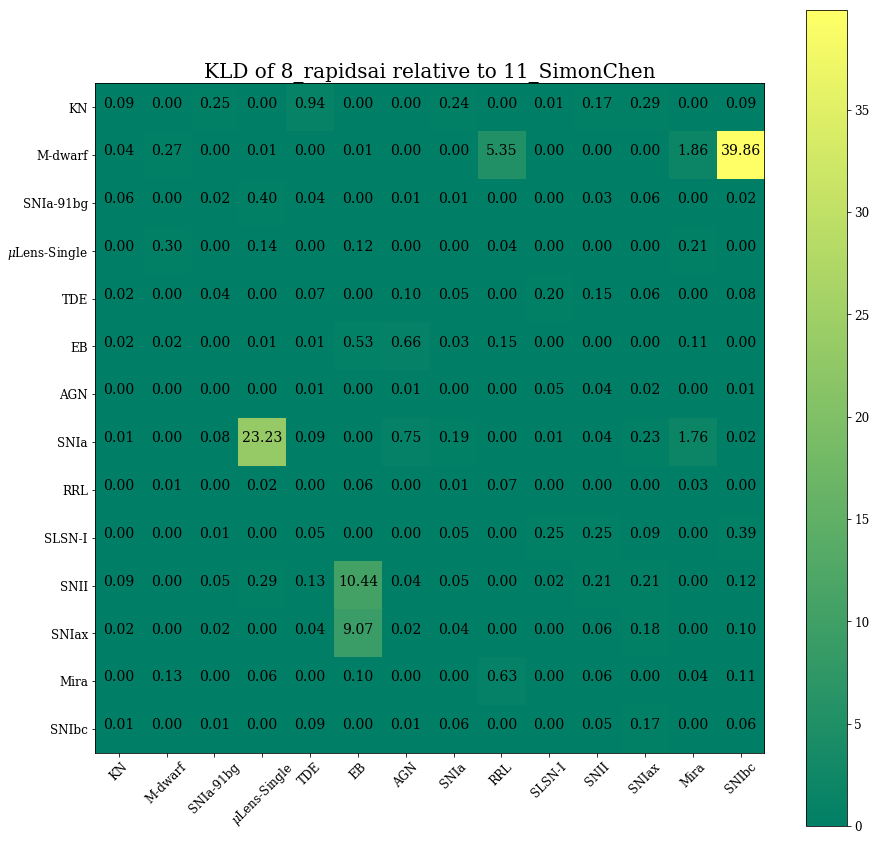

In [11]:
# one_ex = contestants[7]
# contestant_true = contestants[7]
# contestant_approx = contestants[9]

# fig = plt.figure(figsize=(15,15))
# ax = plt.gca()
# plt.title('KLD of %s relative to %s'%(contestant_true, contestant_approx))
# m = ax.imshow(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'], interpolation='nearest', cmap=plt.cm.summer, 
#               vmin=0., vmax=np.amax(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx']))
# tick_marks = np.arange(nlab)
# ax.set_xticks(tick_marks)
# ax.set_xticklabels(label_dict.values(), rotation=45, size=12)
# ax.set_yticks(tick_marks)
# ax.set_yticklabels(label_dict.values(), size=12)

# fig.colorbar(m, ax=ax)

# for k, l in itertools.product(range(nlab), range(nlab)):
# #     if k == l:
# #         continue
# #     else:
#     thresh = np.amax(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx']) / 2.
#     ax.text(l, k, format(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'][k, l], '.2f') ,
#                 horizontalalignment="center", size=14,
#                color="black")# if num[k, l] > thresh else "white")

plot one example, classifier vs. classifier KLD 

In [12]:
nwin = len(contestants)
summarized_klds = np.zeros((nwin, nwin))
nam = np.chararray((nwin, nwin), itemsize=30)
percent_kld = np.zeros((nwin, nwin))

for k, contestant_true in enumerate(contestants):
    for l, contestant_approx in enumerate(contestants):
        if l >= k:
            summarized_klds[k][l] = np.sum(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'])
            vsum = np.sum(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx'], axis=1)
            nam[k, l] = list(label_dict.values())[np.argmax(vsum)]
            percent_kld[k, l] = max(vsum)/sum(vsum)
            #print(max(vsum), summarized_klds[k][l])
            if l == k and ~np.isclose(summarized_klds[k][l], 0.):
                print((contestant_true+'_as_true', contestant_approx+'_as_approx'))
                print(np.max(moar_klds[contestant_true+'_as_true'][contestant_approx+'_as_approx']))

/home/aimalz/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


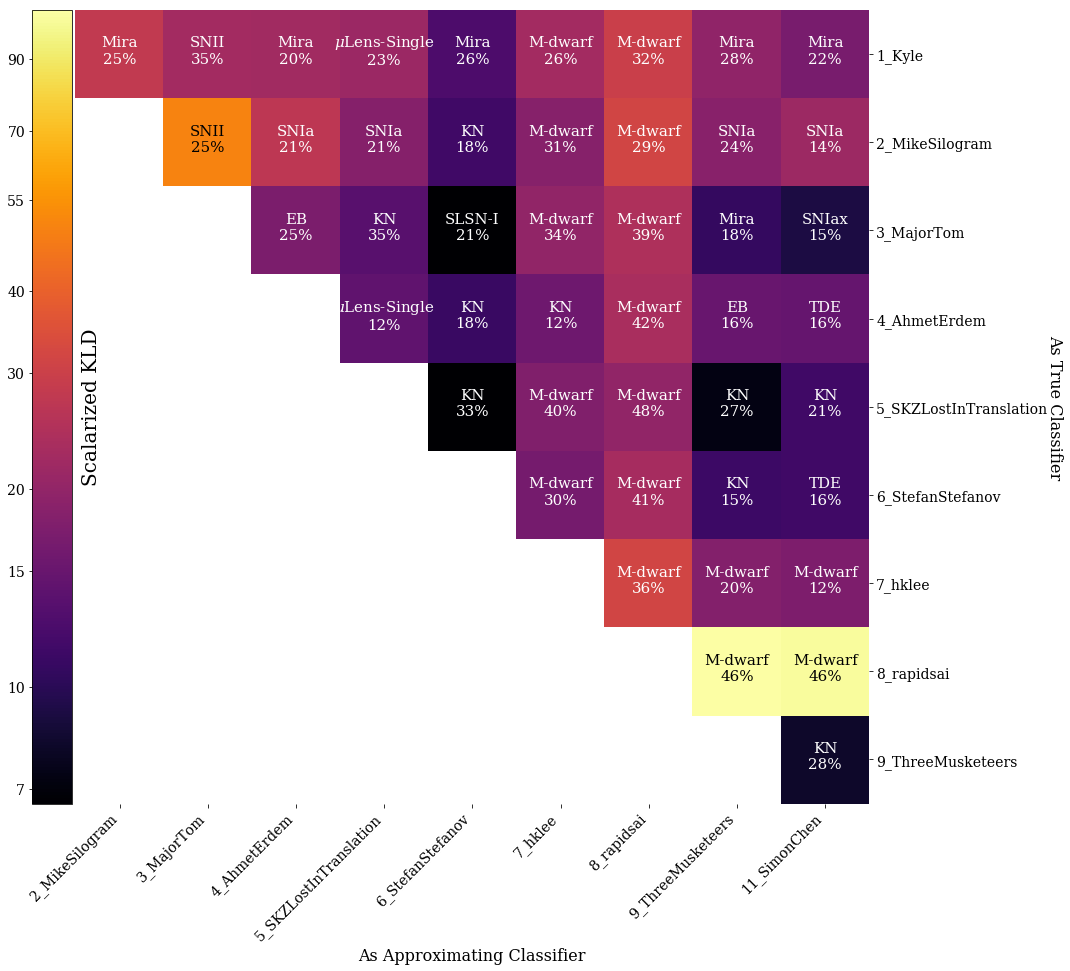

In [13]:
fig = plt.figure(figsize=(15,15))
ax = plt.gca()
#plt.title('integrated KLDs')

colMap = plt.cm.inferno
colMap.set_under(color='white')

m = ax.imshow(summarized_klds[:-1,1:], interpolation='nearest', cmap=colMap, 
              norm=LogNorm(vmin=np.amin(summarized_klds[np.where(summarized_klds>0)]), 
                           vmax=np.amax(summarized_klds)))

tick_marks = np.arange(nwin-1)
ax.set_xticks(tick_marks)
ax.set_xticklabels(contestants[1:], rotation=45, size=14, ha='right')
ax.set_yticks(tick_marks)
ax.set_yticklabels(contestants[:-1], size=14)
ax.set_ylabel("As True Classifier", rotation=270, labelpad=15)
ax.set_xlabel("As Approximating Classifier")

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.05)
cbar = fig.colorbar(m, cax=cax, ticks=[7, 10, 15, 20, 30, 40, 55, 70, 90, 110])
cax.yaxis.set_ticks_position('left')
cbar.set_label(label='Scalarized KLD', fontsize=20, labelpad=10)
cbar.ax.set_yticklabels([7, 10, 15, 20, 30, 40, 55, 70, 90, 110], fontsize=14)

sk = summarized_klds[:-1,1:]
nsk = nam[:-1,1:]
pk = percent_kld[:-1,1:]

for k, l in itertools.product(range(nwin-1), range(nwin-1)):
    thresh = np.amax(sk) / 3.
    if sk[k, l] > 0:
        ax.text(l, k+0.1, nsk[k,l].decode("utf-8")+'\n'+format(pk[k, l]*100, '.0f')+'%' ,
                    horizontalalignment="center", size=15,
                   color="black" if sk[k, l] > thresh else "white")

    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('kld_inferno_labels_percent_11.pdf', bbox_inches='tight')

### RMSE

Between classifier pairs

In [ ]:
from sklearn.metrics import (mean_squared_error, r2_score, max_error,
                            mean_squared_log_error, median_absolute_error)
                             #mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance

func = [mean_squared_error, r2_score, max_error, mean_squared_log_error, median_absolute_error]

dm = np.zeros((len(label_dict), len(label_dict), len(contestants)-1, len(func)))

for i, one_target in enumerate(label_dict.keys()):
    for j, cl_est in enumerate(label_dict.keys()):
        kthepath = os.path.join('submissions/1_Kyle', 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
        kyle = np.genfromtxt(kthepath)
        if np.all(kyle == 0.):
            kyle[0] = 1. / dx
        infcheck = np.isinf(kyle)
        nancheck = np.isnan(kyle)
        if np.any(infcheck):
            kyle[infcheck] = 1. / sum(infcheck) / dx
            kyle[~infcheck] = 0.
        elif np.any(nancheck):
            kyle[nancheck] = 1. / sum(nancheck) / dx
            kyle[~nancheck] = 0.
        norm = np.sum(kyle * dx)
        if not np.isclose(norm, 1.):
            kyle = kyle / norm
        assert(np.isclose(1., np.sum(kyle * dx)))

        for k, contestant in enumerate(contestants[1:]):
            
            thepath = os.path.join('submissions/'+contestant, 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
            data = np.genfromtxt(thepath)
            if np.all(data == 0.):
                data[0] = 1. / dx
            infcheck = np.isinf(data)
            nancheck = np.isnan(data)
            if np.any(infcheck):
                data[infcheck] = 1. / sum(infcheck) / dx
                data[~infcheck] = 0.
            elif np.any(nancheck):
                data[nancheck] = 1. / sum(nancheck) / dx
                data[~nancheck] = 0.
            norm = np.sum(data * dx)
            if not np.isclose(norm, 1.):
                data = data / norm
            assert(np.isclose(1., np.sum(data * dx)))
                
            #print("Compare "+contestant+"'s true "+label_dict[one_target]+" assigned "+sub_labels[cl_est] + ' to Kyle')
            #print(mean_squared_error(kyle, data), mean_squared_log_error(kyle, data), 
            #      r2_score(kyle, data), max_error(kyle, data), median_absolute_error(kyle, data))
            #print('kyle', kyle, '\ndata: ', data)
            for l, f in enumerate(func):
                dm[i, j, k, l] = f(kyle, data)
                
                


### Wasserstein distance

Between classifier pairs

In [ ]:
from scipy.stats import wasserstein_distance
import itertools

In [ ]:
data_dict = {}
for one_target in label_dict.keys():
    data_dict[one_target] = {}
    for cl_est in label_dict.keys():
        data_dict[one_target][cl_est] = {}
        for contestant in contestants:
            thepath = os.path.join('submissions/'+contestant, 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
            data = np.genfromtxt(thepath)
            if np.all(data == 0.):
                data[0] = 1. / dx
            infcheck = np.isinf(data)
            nancheck = np.isnan(data)
            if np.any(infcheck):
                data[infcheck] = 1. / sum(infcheck) / dx
                data[~infcheck] = 0.
            elif np.any(nancheck):
                data[nancheck] = 1. / sum(nancheck) / dx
                data[~nancheck] = 0.
            norm = np.sum(data * dx)
            if not np.isclose(norm, 1.):
                data = data / norm
            assert(np.isclose(1., np.sum(data * dx)))
#             print("I just read in "+contestant+"'s violin curve of true "+label_dict[one_target]+" assigned "+sub_labels[cl_est])
            data_dict[one_target][cl_est][contestant] = data

In [ ]:
target_pairs = list(itertools.combinations(list(label_dict.keys()),2))
contestant_pairs = list(itertools.combinations(list(contestants),2))

# print(list(target_pairs))
# print(list(contestant_pairs))

res_dict = {}
for cp in list(contestant_pairs):
    res_dict[cp] = {}
    for tp in list(target_pairs):
#         print(cp,tp)
        wd = wasserstein_distance(data_dict[tp[0]][tp[1]][cp[0]],data_dict[tp[0]][tp[1]][cp[1]])
        res_dict[cp][tp] = wd
for cp in list(contestant_pairs):
    for tp in list(label_dict.keys()):
#         print(cp,tp)
        wd = wasserstein_distance(data_dict[tp][tp][cp[0]],data_dict[tp][tp][cp[1]])
        res_dict[cp][(tp,tp)] = wd

In [ ]:
# data_dict[90][92]['1_Kyle'],data_dict[90][92]['2_MikeSilogram']

In [ ]:
# res_dict

In [ ]:
disagree_matrices = {}
for cp in list(contestant_pairs):
    matrix = np.ndarray((len(label_dict.keys()),len(label_dict.keys())))
    for i,one_target in enumerate(list(label_dict.keys())):
        for j,cl_est in enumerate(list(label_dict.keys())):
            if (one_target,cl_est) in res_dict[cp].keys():
                matrix[i][j] = res_dict[cp][(one_target,cl_est)]
            elif (cl_est,one_target) in res_dict[cp].keys():
                matrix[i][j] = res_dict[cp][(cl_est,one_target)]               
    disagree_matrices[cp] = matrix

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

def make_disagreement(contestant_pair):
    cp = contestant_pair
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.title('%s and %s'%(contestant_pair[0],contestant_pair[1]))
    m = ax.imshow(disagree_matrices[cp], interpolation='nearest', cmap=plt.cm.summer,
                       vmin=0., vmax=np.amax(disagree_matrices[cp]))
    tick_marks = np.arange(len(label_dict))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(label_dict, rotation=45, size=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(label_dict, size=12)

    for k, l in itertools.product(range(disagree_matrices[cp].shape[0]), range(disagree_matrices[cp].shape[1])):
        if i == j:
            thresh = disagree_matrices[cp].max() / 2.
        else:
            thresh = np.amax(disagree_matrices[cp]) / 2.
        ax.text(l, k, format(disagree_matrices[cp][k,l], '.2f'),
                 horizontalalignment="center",
                 color="black" if disagree_matrices[cp][k, l] > thresh else "white")

In [ ]:
import matplotlib.pyplot as plt
for cp in list(contestant_pairs[0:]):
#     plt.imshow(disagree_matrices[cp])
#     plt.show()
    make_disagreement(cp)
    plt.show()

In [ ]:
def plot_matrix(matrix):
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
#     plt.title('%s and %s'%(contestant_pair[0],contestant_pair[1]))
    m = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.summer,
                       vmin=0., vmax=np.amax(matrix))
    tick_marks = np.arange(np.shape(matrix)[0])
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(contestants, rotation=45, size=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(contestants, size=12)

    for k, l in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if i == j:
            thresh = disagree_matrices[cp].max() / 2.
        else:
            thresh = np.amax(matrix) / 2.
        ax.text(l, k, format(matrix[k,l], '.2f'),
                 horizontalalignment="center",
                 color="black" if matrix[k, l] > thresh else "white")

In [ ]:
sumsq_matrix = np.zeros((10,10))
for cp in list(contestant_pairs[0:]):
    i = int(cp[0].split('_')[0])-1
    j = int(cp[1].split('_')[0])-1
#     print(i,j)
    sumsq_matrix[i,j] = np.sum(disagree_matrices[cp]**2)
plot_matrix(sumsq_matrix)
plt.title("Sum square of each disagreement pair")
plt.show()

## Visualizing metrics

Plot the per-true-class, per-assigned-class, per-classifier metrics as a per-classifier $N_{class} \times N_{class}$ matrix

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

for i, contestant in enumerate(contestants[1:]):
    for j, f in enumerate(func):
        fig = plt.figure(figsize=(10,10))
        ax = plt.gca()
        plt.title('%s %s'%(contestant, str(f)))
        m = ax.imshow(dm[:, :, i, j], interpolation='nearest', cmap=plt.cm.summer,
                           vmin=0., vmax=np.amax(dm[:, :, i, j]))
        tick_marks = np.arange(len(label_dict))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(label_dict.values(), rotation=45, size=12)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(label_dict.values(), size=12)
        
        for k, l in itertools.product(range(dm[:, :, i, j].shape[0]), range(dm[:, :, i, j].shape[1])):
            if i == j:
                thresh = dm[:, :, i, j].max() / 2.
            else:
                thresh = np.amax(dm[:, :, i, j]) / 2.
            ax.text(l, k, format(dm[k, l, i, j], '.2f'),
                     horizontalalignment="center",
                     color="black" if dm[:, :, i, j][k, l] > thresh else "white")

## Summarizing metrics

Combine per-true-class, per-assigned-class, per-classifier-pair metrics into one scalar value per pair of classifiers

### KAP: an option for disagreement matrix
#### done using RMSE as metric

In [ ]:
metric = mean_squared_error

dm1 = np.zeros((len(label_dict), len(label_dict), len(contestants), len(contestants)))

for i, one_target in enumerate(label_dict.keys()):
    for j, cl_est in enumerate(label_dict.keys()):
        for k, contestant in enumerate(contestants):
            kthepath = os.path.join('submissions/'+contestant, 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
            kyle = np.genfromtxt(kthepath)
            if np.all(kyle == 0.):
                kyle[0] = 1. / dx
            infcheck = np.isinf(kyle)
            nancheck = np.isnan(kyle)
            if np.any(infcheck):
                kyle[infcheck] = 1. / sum(infcheck) / dx
                kyle[~infcheck] = 0.
            elif np.any(nancheck):
                kyle[nancheck] = 1. / sum(nancheck) / dx
                kyle[~nancheck] = 0.
            norm = np.sum(kyle * dx)
            if not np.isclose(norm, 1.):
                kyle = kyle / norm
            assert(np.isclose(1., np.sum(kyle * dx)))

            for l, contestant1 in enumerate(contestants):
                #print(contestant, contestant1)
                thepath = os.path.join('submissions/'+contestant1, 'violin'+str(one_target)+'true'+str(cl_est)+'pred.txt')
                data = np.genfromtxt(thepath)
                if np.all(data == 0.):
                    data[0] = 1. / dx
                infcheck = np.isinf(data)
                nancheck = np.isnan(data)
                if np.any(infcheck):
                    data[infcheck] = 1. / sum(infcheck) / dx
                    data[~infcheck] = 0.
                elif np.any(nancheck):
                    data[nancheck] = 1. / sum(nancheck) / dx
                    data[~nancheck] = 0.
                norm = np.sum(data * dx)
                if not np.isclose(norm, 1.):
                    data = data / norm
                assert(np.isclose(1., np.sum(data * dx)))

                dm1[i, j, k, l] = metric(kyle, data)

In [ ]:
# axis = 0 sums over prediction
# axis = 1 sums over true

num = np.zeros((len(contestants), len(contestants)))
nam = np.chararray((len(contestants), len(contestants)), itemsize=30)

for i in range(0,len(contestants)):
    for j in range(0,len(contestants)):
        s = np.sum(dm1[:,:, i, j], axis=1)
        a = np.argmax(s)
        num[i,j] = s[a]
        nam[i,j] = list(label_dict.values())[a]

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.gca()
#plt.title('%s %s'%(contestant, str(f)))
m = ax.imshow(num, interpolation='nearest', cmap=plt.cm.summer,
                   vmin=0., vmax=np.amax(num))
tick_marks = np.arange(len(contestants))
ax.set_xticks(tick_marks)
ax.set_xticklabels(contestants, rotation=45, size=12)
ax.set_yticks(tick_marks)
ax.set_yticklabels(contestants, size=12)

fig.colorbar(m, ax=ax)

for k, l in itertools.product(range(num.shape[0]), range(num.shape[1])):
    if k == l:
        continue
    else:
        thresh = np.amax(num) / 2.
        ax.text(l, k, nam[k,l].decode("utf-8")+'\n'+format(num[k, l], '.2f') ,
                horizontalalignment="center", size=14,
               color="black" if num[k, l] > thresh else "white")


### Sum and Average over all values in Contestant v Contestant disagreement metric matrix

In [ ]:
summed = np.zeros((len(contestants), len(contestants)))
averaged = np.zeros((len(contestants), len(contestants)))

for i in range(0,len(contestants)):
    for j in range(0,len(contestants)):
        summed[i, j] = np.sum(dm1[:,:, i, j])
        averaged[i, j] = np.average(dm1[:,:, i, j])

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.gca()
plt.title('Summed disagreement across all classes')
m = ax.imshow(summed, interpolation='nearest', cmap=plt.cm.summer,
                   vmin=0., vmax=np.amax(summed))
tick_marks = np.arange(len(contestants))
ax.set_xticks(tick_marks)
ax.set_xticklabels(contestants, rotation=45, size=12)
ax.set_yticks(tick_marks)
ax.set_yticklabels(contestants, size=12)

fig.colorbar(m, ax=ax)

for k, l in itertools.product(range(summed.shape[0]), range(summed.shape[1])):
    if k == l:
        continue
    else:
        thresh = np.amax(num) / 2.
        ax.text(l, k, format(summed[k, l], '.2f'),
                horizontalalignment="center", size=14,
               color="black" if num[k, l] > thresh else "white")
        
 

fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.title('Averaged disagreement across all classes')
m = ax.imshow(averaged, interpolation='nearest', cmap=plt.cm.summer,
                   vmin=0., vmax=np.amax(averaged))
tick_marks = np.arange(len(contestants))
ax.set_xticks(tick_marks)
ax.set_xticklabels(contestants, rotation=45, size=12)
ax.set_yticks(tick_marks)
ax.set_yticklabels(contestants, size=12)

fig.colorbar(m, ax=ax)

for k, l in itertools.product(range(averaged.shape[0]), range(averaged.shape[1])):
    if k == l:
        continue
    else:
        thresh = np.amax(num) / 2.
        ax.text(l, k, format(averaged[k, l], '.2f') ,
                horizontalalignment="center", size=14,
               color="black" if num[k, l] > thresh else "white")